### Fine tuning the fine tune

This notebook will walk through the steps to customize the [stable-diffusion-inpainting](https://huggingface.co/runwayml/stable-diffusion-inpainting) model from runwayml.

In [7]:
!git clone https://github.com/lrav35/diffusion.git

Cloning into 'diffusion'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 146 (delta 5), reused 33 (delta 3), pack-reused 105
Receiving objects: 100% (146/146), 83.47 MiB | 33.21 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [8]:
!pip install -r diffusion/requirements.txt

  Using cached accelerate-0.28.0-py3-none-any.whl (290 kB)
  Using cached bitsandbytes-0.42.0-py3-none-any.whl (105.0 MB)
  Using cached diffusers-0.27.2-py3-none-any.whl (2.0 MB)
  Using cached huggingface_hub-0.21.4-py3-none-any.whl (346 kB)
  Using cached transformers-4.39.1-py3-none-any.whl (8.8 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [6]:
# !rm -rf diffusion

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
from io import BytesIO
import requests
import os

from huggingface_hub import snapshot_download
from diffusers import StableDiffusionInpaintPipeline
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [10]:
def display_image_grid(images, size=256):
  imgs = [img.resize((size, size)) for img in images]
  grid_shape = (1,len(images))
  w, h = size, size
  rows, cols = grid_shape[0], grid_shape[1]
  grid = Image.new("RGB", size=(cols * w, rows * h))
  for i, image in enumerate(imgs):
    grid.paste(image, box=(i % cols * w, i // cols * h))
  return grid

First, we are going to teach our model about my cat, Stella! We will fine tune the inpainting model on six images of her and gain the ability to put her in different settings. Sure, stable diffusion could generate a cat, but it wouldn't be the real Stella. Let's see how this goes.

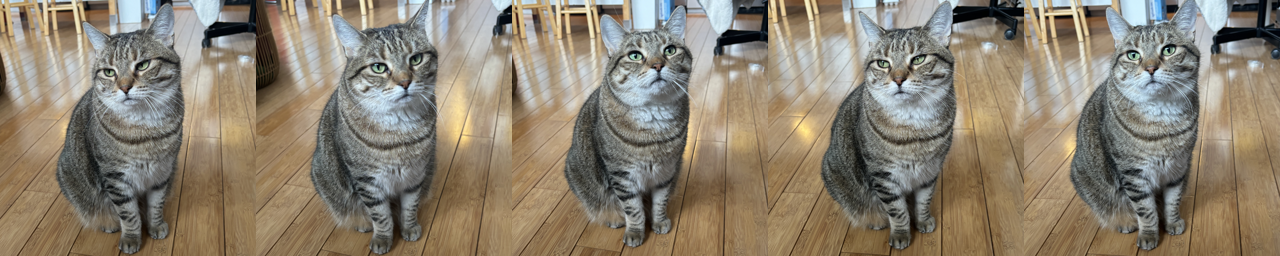

In [11]:
path = "diffusion/stella/*.JPG"
images = [Image.open(pth) for pth in glob.glob(path)]

display_image_grid(images)

In [ ]:
# local_dir = "./images/dog/"
# snapshot_download(
#     "diffusers/dog-example",
#     local_dir=local_dir, repo_type="dataset",
#     ignore_patterns=".gitattributes",
# )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/content/images/dog'

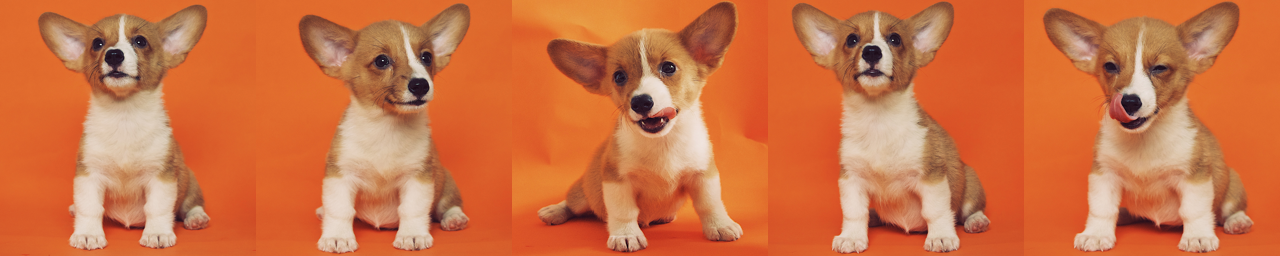

In [ ]:
# path = "images/dog/*.jpeg"
# images = [Image.open(pth) for pth in glob.glob(path)]

# display_image_grid(images)

But first, let's see what the model can do first before fine tuning.

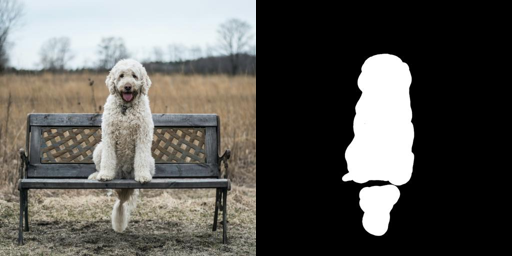

In [15]:
def download_image(url, dir, name):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB").resize((512,512))
    if not os.path.exists(dir):
        os.makedirs(dir) # Create directory if it doesn't exist
    image_path = os.path.join(dir, name)
    image.save(image_path)
    return image_path

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = download_image(img_url, "test_images", "dog_on_bench.jpeg")
mask_image = download_image(mask_url, "test_images", "bench_mask.jpeg")
images = [image, mask_image]
display_image_grid([Image.open(image) for image in images])

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt = "a cartoon bird sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0)

image = Image.open(image)
mask_image = Image.open(mask_image)

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

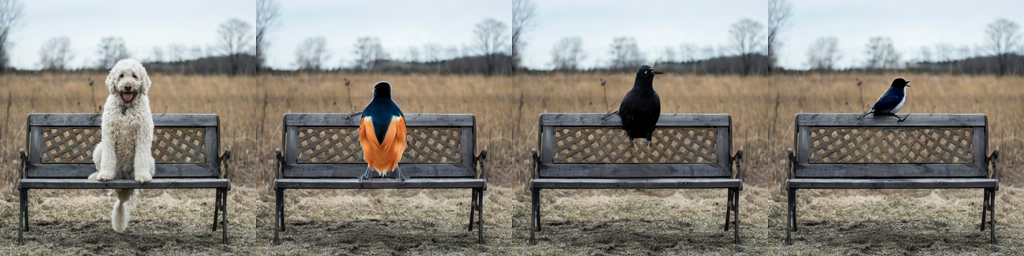

In [ ]:
images.insert(0, image)
display_image_grid(images, 1, num_samples + 1)

## Model Training

In [ ]:
# run if GPU VRAM has data on it from a previous run
torch.cuda.empty_cache()

In [ ]:
 # TODO: add wandb loss plot

In [12]:
!accelerate launch diffusion/fine_tune_dreambooth.py \
              --prompt="a photo of stella the cat" \
              --input_data_dir="diffusion/stella/" \
              --max_train_steps=500 \
              --train_batch_size=1

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-04-04 11:55:08.782505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 11:55:08.782560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 11:55:08.784192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

How did it work? Let's try some generations

In [13]:
# Load the pretrained model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "diffusion-inpainting",
    torch_dtype=torch.float16
)
pipe.to('cuda')


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

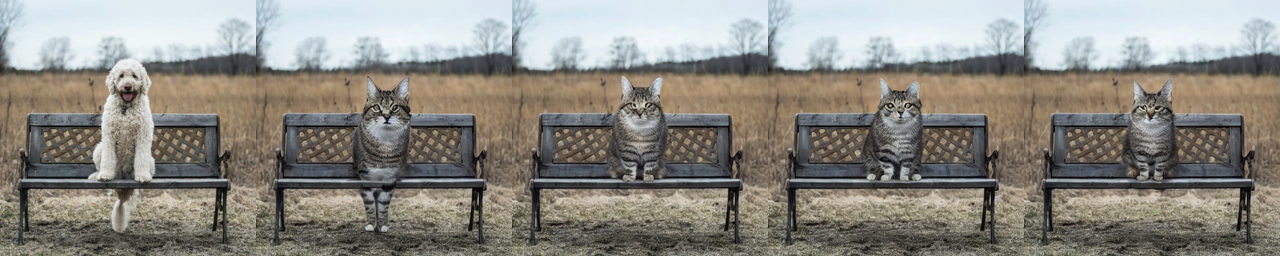

In [24]:
image = Image.open("test_images/dog_on_bench.jpeg")
mask = Image.open("test_images/bench_mask.jpeg")
images = pipe(prompt=["a photo of stella the cat"]*4, image=image, mask_image=mask).images
images.insert(0, image) # insert original for comparison
display_image_grid(images)

  0%|          | 0/50 [00:00<?, ?it/s]

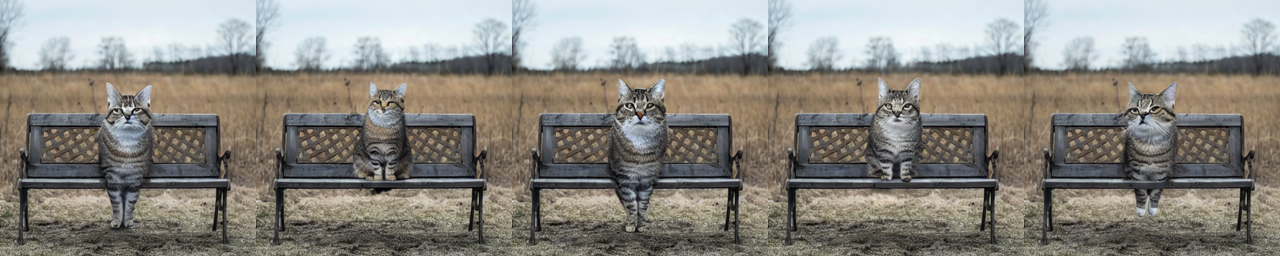

In [27]:
# more samples
images = pipe(prompt=["a photo of stella the cat"]*5, image=image, mask_image=mask).images
display_image_grid(images)

Stella! kind of..

TODO:
*   train w/ cat images
*  get more image/mask pairs
*  train with hat images for ecommerce
*  notebook needs a lot of cleanup/formatting
*  Do i need a loss plot? it might not provide any info
* eval metrics? kind of subjective